### Check tf preprocessing pipeline with AZ videos ###

In [61]:
import os
import glob
import pickle
import pandas as pd
import numpy as np
import time
import tensorflow as tf
from matplotlib import pyplot as plt

# Custom imports
from werdich_cfr.utils.processing import Videoconverter
from werdich_cfr.tfutils.TFRprovider import DatasetProvider

In [11]:
# Video selection criteria
max_frame_time_ms = 33.34 # Maximum frame_time acceptable in ms
min_rate = 1/max_frame_time_ms*1e3
min_frames = 40 # Minimum number of frames at min_rate (2 s)
min_length = max_frame_time_ms*min_frames*1e-3

In [2]:
# Load BW metadata as example
dev_dir = os.path.normpath('/mnt/obi0/andreas/data/cfr_AZ')
bwmeta_file_name = 'bwh_metadata.parquet'
bwmeta = pd.read_parquet(os.path.join(dev_dir, bwmeta_file_name))
display(bwmeta.head(2))

,filename,frame_time,deltaX,deltaY,dir,prev_preds
0,48b4c0c643454479_4903a58051d59c1632a2417b35c5_...,17.940552,0.044297,0.044297,/mnt/obi0/phi/echo/npyFiles/BWH/48b4/48b4c0c64...,1.596508
1,48b4c0c64adf5e8d_4903a58051d59c17833b0801157e_...,33.333000,0.044040,0.044040,/mnt/obi0/phi/echo/npyFiles/BWH/48b4/48b4c0c64...,2.038057


In [17]:
bwmeta.iloc[0].filename

'48b4c0c643454479_4903a58051d59c1632a2417b35c5_Image-32.npy.lz4'

### Load AZ videos into memory ###

In [23]:
# Video list
az_dir = os.path.normpath('/mnt/obi0/sgoto/AZ_Project')
az_echo_dir = os.path.join(az_dir, 'npyFiles')
video_meta_file_name = 'metadata.tsv'
video_meta_file = os.path.join(az_dir, video_meta_file_name)
video_meta_df = pd.read_csv(video_meta_file, sep='\t')
# Some small adjustments to this data frame
video_meta_df = video_meta_df.dropna(subset=['frametime']).\
    rename(columns={'frametime': 'frame_time'}).\
    reset_index(drop=True)
video_meta_df['filename'] = video_meta_df['filename']+'.npy.lz4'
video_meta_df['dir'] = az_echo_dir
file_list = list(video_meta_df.filename.unique())[:16]
display(video_meta_df.head())

,Unnamed: 0,filename,frame_time,deltaX,deltaY,dir
0,0,KX00002F.npy.lz4,17.363,-0.033333,0.033333,/mnt/obi0/sgoto/AZ_Project/npyFiles
1,3,KX000037.npy.lz4,18.690,-0.031667,0.031667,/mnt/obi0/sgoto/AZ_Project/npyFiles
2,6,KX00001D.npy.lz4,16.646,-0.031667,0.031667,/mnt/obi0/sgoto/AZ_Project/npyFiles
3,9,KX000005.npy.lz4,16.646,-0.031667,0.031667,/mnt/obi0/sgoto/AZ_Project/npyFiles
4,12,KX0000C5.npy.lz4,16.490,-0.028333,0.028333,/mnt/obi0/sgoto/AZ_Project/npyFiles


In [24]:
#%% Load video data into memory and start preprocessing
print(f'Loading {len(file_list)} echos into memory from file: {os.path.basename(video_meta_file_name)}.')

# Image processing class
VC = Videoconverter(max_frame_time_ms=max_frame_time_ms, min_frames=min_frames, meta_df=video_meta_df)

image_array_file_list = []
image_array_list = []
meta_disqualified_list = []
start_time = time.perf_counter()
for f, filename in enumerate(file_list):

    if (f+1) % 10 == 0:
        time_passed = (time.perf_counter()-start_time)/60
        print(f'Loading file {f+1} of {len(file_list)}: {filename}. Time: {time_passed:.2f}')

    error, im = VC.process_video(filename)

    if np.any(im):
        image_array_list.append((im, np.asarray(im.shape, np.int32)))
        image_array_file_list.append(filename)
    else:
        meta_disqualified_list.append(video_meta_df[video_meta_df.filename == filename].\
                                      assign(err=[error]))
        print('Skipping this one.')

if len(meta_disqualified_list) > 0:
    echo_df_disqualified = pd.concat(meta_disqualified_list, ignore_index=True)
    # Save disqualified metadata
    print(f'Found {echo_df_disqualified.shape[0]} of {len(file_list)} disqualified videos.')
    disqualified_filename = os.path.basename(video_meta_file_name).split('.')[0] + '_disqualified.parquet'
    echo_df_disqualified.to_parquet(os.path.join(cfr_project_dir, disqualified_filename))

print(f'Loaded {len(image_array_list)} of {len(file_list)} videos into memory.')

Loading 16 echos into memory from file: metadata.tsv.
Loading file 10 of 16: KX00009D.npy.lz4. Time: 0.17
Loaded 16 of 16 videos into memory.


In [71]:
image_array_list[0]

(array([[[  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         ...,
         [246, 246, 246, ..., 246, 246, 246],
         [  0,   0,   0, ...,   0,   0,   0],
         [  2,   2,   2, ...,   2,   2,   2]],
 
        [[  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         ...,
         [  6,   6,   6, ...,   6,   6,   6],
         [  3,   3,   3, ...,   3,   3,   3],
         [  6,   6,   6, ...,   6,   6,   6]],
 
        [[  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         ...,
         [191, 191, 191, ..., 191, 191, 191],
         [  7,   7,   7, ...,   7,   7,   7],
         [  4,   4,   4, ...,   4,   4,   4]],
 
        ...,
 
        [[  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,

In [37]:
# Features for the model
meta_date = '200617'
cfr_project_dir = os.path.normpath('/mnt/obi0/andreas/data/cfr_AZ')
model_dir = os.path.join(cfr_project_dir, 'models')
feature_dict_name = 'feature_dict_' + 'tfr_' + meta_date+'.pkl'
feature_dict_file = os.path.join(model_dir, feature_dict_name)
with open(feature_dict_file, 'rb') as fl:
    feature_dict = pickle.load(fl)

model_dir = os.path.join(cfr_project_dir, 'models')
checkpoint_list = 'cfr_correlations_bestmodels_30FPS.parquet'
checkpoint_df = pd.read_parquet(os.path.join(cfr_project_dir, 'models', checkpoint_list))
model_list = sorted(list(checkpoint_df.model_name.unique()))

# Model hyperparameters and output name
model_name = model_list[0]
model_dict_file_name = model_name + '_model_dict.pkl'
model_dict_file = os.path.join(model_dir, model_dict_file_name)
with open(model_dict_file, 'rb') as fl:
    model_dict = pickle.load(fl)
model_output = model_dict['model_output']

In [31]:
def get_im_generator(im_array_list):
    """ Yield successive images from list """
    def im_generator():
        for element in im_array_list:
            yield (element[0], element[1])
    return im_generator

In [42]:
batch_size = 8
im_generator = get_im_generator(image_array_list)
dsp = DatasetProvider(augment=False,
                      im_scale_factor=model_dict['im_scale_factor'],
                      feature_dict=feature_dict)
dset = tf.data.Dataset.from_generator(generator=im_generator,
                                          output_types=(tf.int32, tf.int32),
                                          output_shapes=(tf.TensorShape([None, None, model_dict['n_frames']]),
                                                         tf.TensorShape([3])))
dset = dset.map(dsp._process_image)
dset = dset.map(lambda x: ({'video': x}, {'score_output': 0}))
dset = dset.batch(batch_size=batch_size, drop_remainder=False).repeat(count=1)

In [57]:
for out in dset.take(1):
    output = out
image_batch = output[0]['video'].numpy()

In [65]:
image_batch.shape

(8, 40, 299, 299, 1)

Video batch shape: (8, 40, 299, 299, 1)


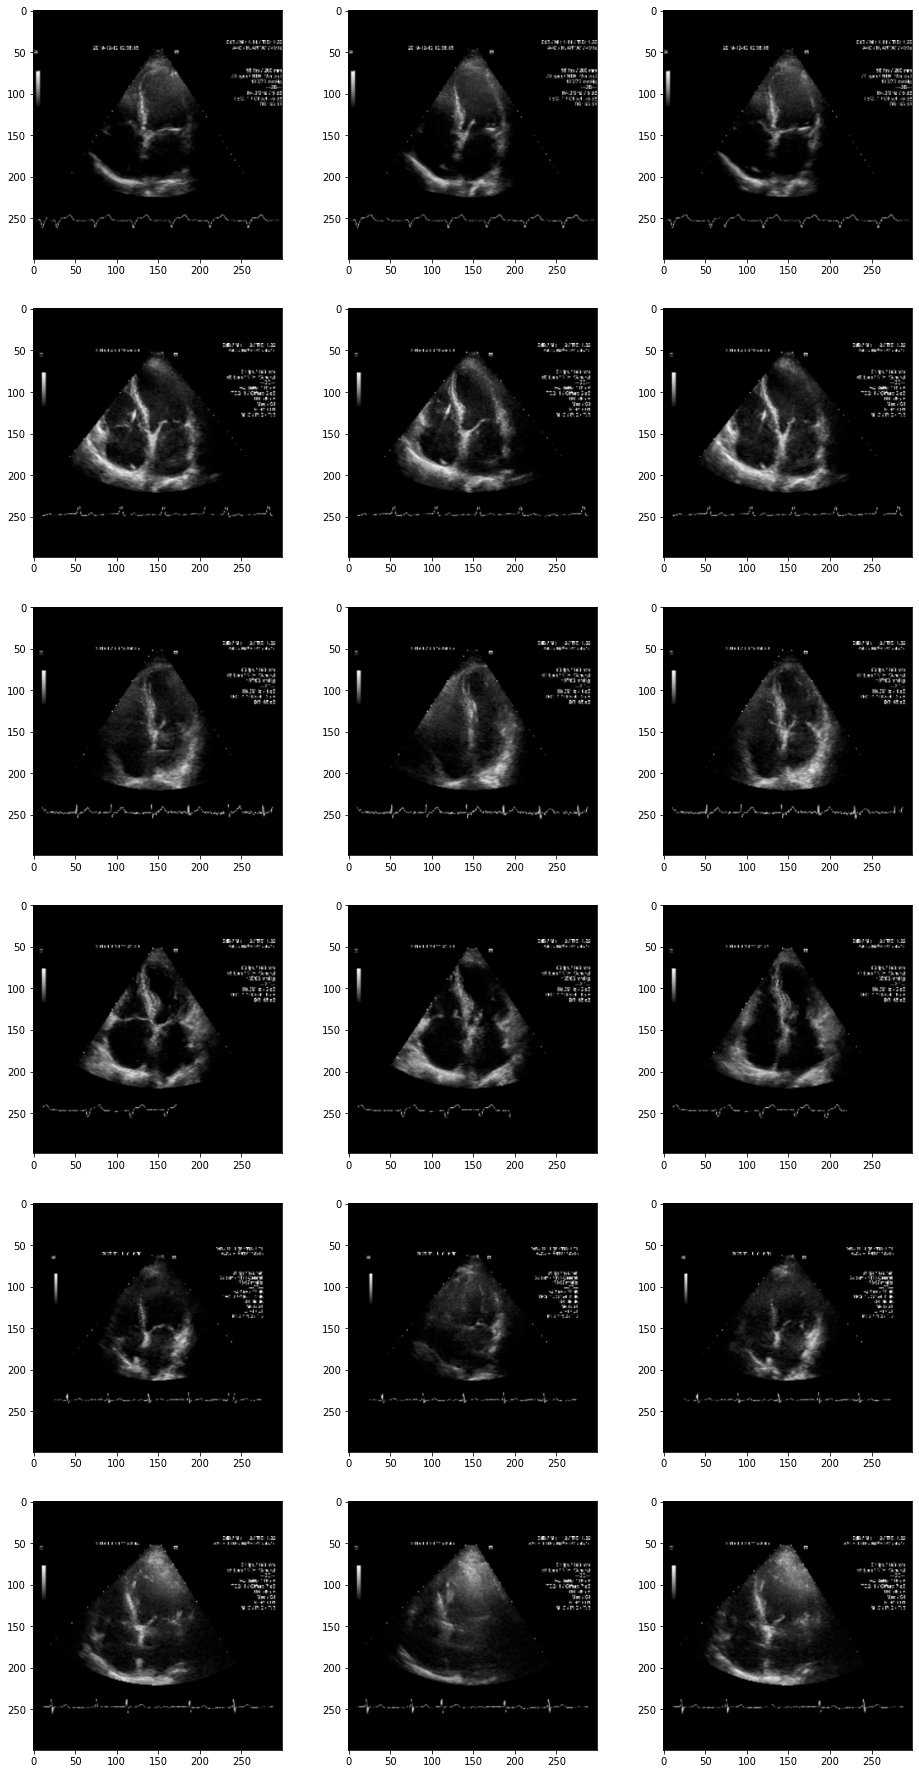

In [69]:
# Output batch is a list of dictionaries [INPUT, OUTPUT]:
image_batch = output[0]['video'].numpy()
print('Video batch shape:', image_batch.shape)

# Show some images from the batch
#sample_idx = np.random.randint(batch_size, size=6)
sample_idx = np.arange(0, 6)
n_frames = 40
frame_idx = np.random.randint(n_frames, size=3)
fig, ax = plt.subplots(nrows=len(sample_idx), ncols=len(frame_idx), figsize = (16, 32))

for row, sample in enumerate(sample_idx):
    for col, frame in enumerate(frame_idx):
        image = np.squeeze(image_batch[sample, frame, :, :, 0])
        ax[row, col].imshow(image, cmap = 'gray')

plt.show()